# Titanic Survival Exploration with Automated Decision Tree

Let's take the Titanic data from the original project and see about using sklearn to build a decision tree with a better accuracy. The accuracy I got from my handmade decision tree was 80.36%.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
in_file = 'titanic_data.csv'
full_data = pd.read_csv(in_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# We know from exploring the data that the Cabin and Ticket columns weren't useful, so let's get rid of them.
data = full_data.drop('Ticket', axis=1)
data = data.drop('Cabin', axis=1)
data = data.drop('Embarked', axis=1)
data = data.drop('Name', axis=1)
data = data.drop('PassengerId', axis=1)

# The DecisionTree requires numeric values.
data['Sex'] = data.Sex.map({'male':0, 'female':1})

# Some ages contain NaN.
data = data.fillna(0.0)

# Split off the survival data.
outcomes = data['Survived']
data = data.drop('Survived', axis=1)

# Generate our testing and training sets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, outcomes, random_state=47, train_size=0.8)

/data/data/com.termux/files/usr/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return (truth == pred).mean()*100    
    else:
        raise ArgumentError("Number of predictions does not match number of outcomes!")
    

In [5]:
# Decision tree!
from sklearn.tree import DecisionTreeClassifier
# experiment: using entropy over gini provides a ~1% increase in accuracy.
def experiment(parameters, iterations=1000):
    total = 0.0
    for i in range(iterations):
        clf = DecisionTreeClassifier(**parameters)
        clf.fit(X_train, y_train)

        # Check our predictions:
        predictions = clf.predict(X_test)
        accuracy = float(accuracy_score(y_test, predictions))
        total += accuracy
    return total / float(iterations)

In [6]:
print(experiment({'criterion':'gini'}))
print(experiment({'criterion':'entropy'}))

77.565921787708731
74.934636871507905


In one such run of the previous cell, the accuracies score were:

* 72.292737430167705 using 'gini' as the criterion
* 73.715083798882532 using 'entropy' as the criterion

Right away, it looks like entropy estimation gives us better results; still, it's far below the 80% minimum the exercise requires. How does presorting affect this?

In [7]:
print(experiment({'criterion':'gini', 'presort':True}))
print(experiment({'criterion':'entropy', 'presort':True}))

77.564804469273
74.949720670390704


On one such run, the accuracies were 72.34% and 73.69% --- not much of an improvement.

In [8]:
base_params = {'criterion':'entropy'}
def entropy_experiment(params, iterations=1000):
    merged = base_params.copy()
    merged.update(params)
    return experiment(merged, iterations)

How does changing the `min_impurity_decrease` parameter affect the accuracy?

In [9]:
# Changing the behavior with an inclusive stop condition.
def frange(x, y, jump):
    if jump >= 0:
        while x <= y:
            yield x
            x += jump
    else:
        while y <= x:
            yield x
            x += jump

def average(lst):
    return float(sum(list)) / float(len(list))

In [10]:
for mpd in frange(0, 1.0, 0.1):
    accuracy = entropy_experiment({'min_impurity_decrease': mpd})
    print(mpd, accuracy)

0 74.946368715083324
0.10000000000000001 82.122905027934777
0.20000000000000001 82.122905027934777
0.30000000000000004 60.893854748603196
0.40000000000000002 60.893854748603196
0.5 60.893854748603196
0.59999999999999998 60.893854748603196
0.69999999999999996 60.893854748603196
0.79999999999999993 60.893854748603196
0.89999999999999991 60.893854748603196
0.99999999999999989 60.893854748603196


Progress! With a `min_purity_decrease` equal to 0.15 (the average of the two best values), we get a better accuracy than we got with the hand-crafted decision tree (82.12% in one such run).

In [11]:
base_params['min_impurity_decrease'] = 0.15
# verify that this works
print(entropy_experiment({}))

82.122905027934777


Okay, we get the same accuracy as before, so that works. What other parameters might provide an increase in our score? What about trying to randomly split the nodes?

In [12]:
print(entropy_experiment({'splitter':'random'}))

82.122905027934777


No change. We'll call this a wrap for now, because it's just meant to be a quick dive into the `DecisionTreeClassifier` and it's already returning a better score than my hand-crafted tree (with just 80.36% accuracy).

What does this tree look like?

training DecisionTreeClassifier
exporting to graphviz


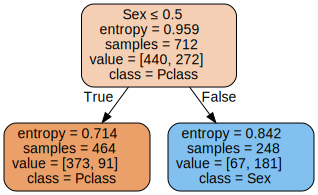

In [13]:
import graphviz
from sklearn.tree import export_graphviz

clf = DecisionTreeClassifier(**base_params)
print("training DecisionTreeClassifier")
clf.fit(X_train, y_train)
print("exporting to graphviz")
dot_data = export_graphviz(clf, out_file=None, 
                          feature_names=data.columns,  
                          class_names=data.columns,  
                          filled=True, rounded=True,  
                          special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render("titanic") # uncomment to write PDF file.
graph

## Addendum

My MLND mentor Lukas reminded me about GridSearchCV. Let's use that to search out the optimum hyperparameters.

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion': ['gini', 'entropy'],
              'min_impurity_decrease': list(frange(1.0, 0.1, -0.1)),
              'splitter': ['random', 'best'],
              'presort': [False, True],
              'min_samples_split': list(range(10, 50, 10))}

clf = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='average_precision', cv=5)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
best_params = clf.best_params_

predictions = clf.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))

Best parameters set found on development set:

{'criterion': 'gini', 'min_impurity_decrease': 0.10000000000000014, 'min_samples_split': 10, 'presort': False, 'splitter': 'random'}
Accuracy: 82.122905027932958


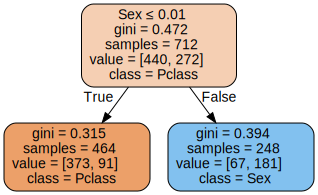

In [20]:
import graphviz
from sklearn.tree import export_graphviz

clf = DecisionTreeClassifier(**best_params)
clf.fit(X_train, y_train)
dot_data = export_graphviz(clf, out_file=None, 
                          feature_names=data.columns,  
                          class_names=data.columns,  
                          filled=True, rounded=True,  
                          special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render("titanic") # uncomment to write PDF file.
graph

In conclusion, the GridSearch found the same minimum impurity decrease as I did (between 0.1 and 0.2). It looks like the criterion parameter didn't really matter; neither did the presort or split parameters. A lower minimum sample split seems to work better, although this would normally be a parameter that I'd observe carefully for signs of a resulting high-variance model.